In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from experiments.src.data import GPData

In [2]:
NOISE_SCALE = 0.15

In [3]:
# Example usage
gp_data = GPData(
    length_scale=1.0,
    sigma_obs=NOISE_SCALE,
    train_size=100,
    test_size=500,
    rff_full_features=20,
    rff_features=20
)

/home/gabor/Projects/bnn-msc/experiments/src/data.py:309: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  f_full = jnp.array(np.random.multivariate_normal(mean=np.zeros(K.shape[0]), cov=K))


In [4]:
# Access data
X_train, y_train = gp_data.train
X_test, y_test = gp_data.test

In [5]:
import statsmodels.api as sm
import numpy as onp
model = sm.OLS(onp.array(y_train[:,0]), onp.array(X_train[:, :])).fit_regularized(alpha=1e-4)

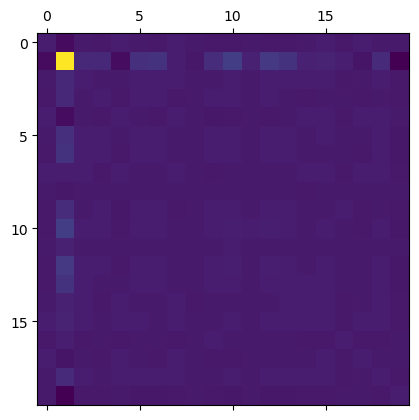

In [6]:
import matplotlib.pyplot as plt
plt.matshow(X_train[:,:].T @ X_train[:,:])

In [7]:
# model.summary()

(-3.5, 2.5)

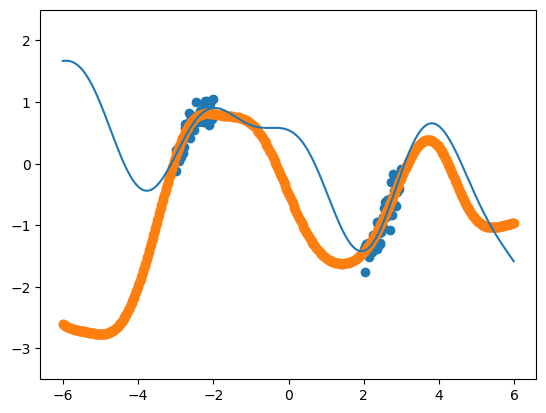

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(
    X_train[:,1],
    y_train,
    label="Train",
)
ax.scatter(
    X_test[:,1],
    y_test,
    label="Test",
)

ax.plot(
    X_test[:, 1],
    model.predict(exog=X_test),
    label="Predict",
)
ax.set_ylim(-3.5, 2.5)

In [9]:
from experiments.src.model import BayesianLinearRegression

In [10]:
blr = BayesianLinearRegression(
    input_dim=X_train.shape[1],
    noise_scale=NOISE_SCALE,
    prior_scale=1,
)

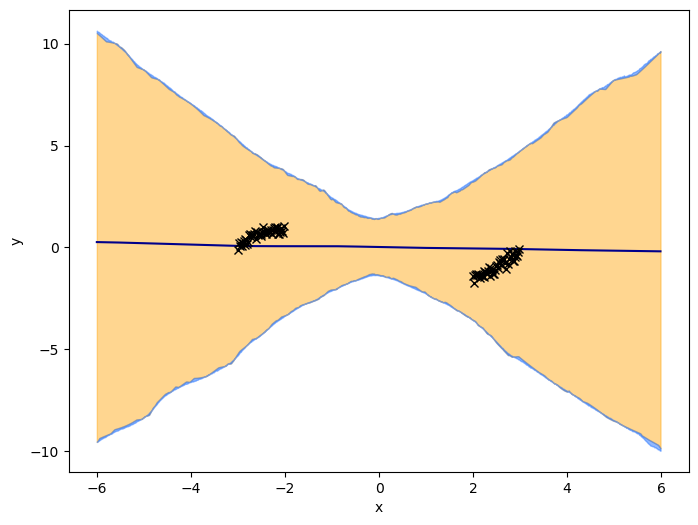

In [11]:
from experiments.src.experiment import *
import jax.random as random
prior_experiment = PriorExperiment(blr, gp_data)
prior_experiment.make_predictions(
    random.PRNGKey(1)
)
_ =prior_experiment.make_plots()

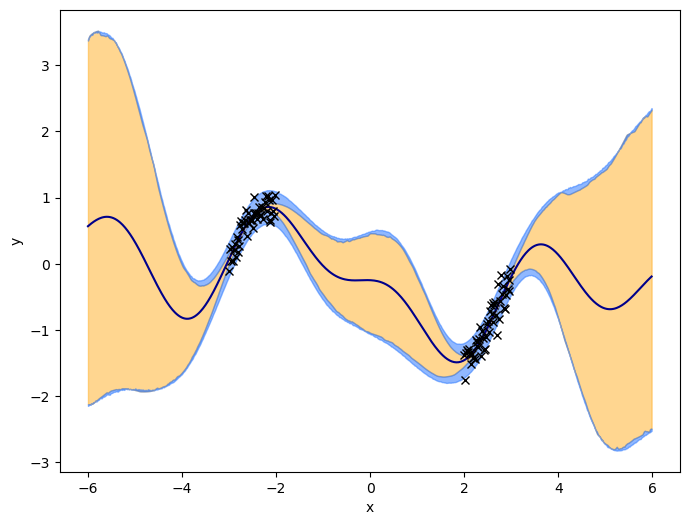

In [12]:
true_experiment = TrueBayesianLinearRegressionExperiment(
    blr,
    gp_data,
)
true_experiment.train(
    random.PRNGKey(1)
)
true_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = true_experiment.make_plots()

Initial eval loss: 704.7966 (lik: -618.4797, kl: 86.3169)


  0%|          | 0/50 [00:00<?, ?it/s]E0327 21:05:53.317577  423641 buffer_comparator.cc:157] Difference at 16: 2.94898, expected -18.9906
E0327 21:05:53.317602  423641 buffer_comparator.cc:157] Difference at 17: 3.242, expected -18.9804
E0327 21:05:53.317605  423641 buffer_comparator.cc:157] Difference at 18: 5.44902, expected -17.86
E0327 21:05:53.317607  423641 buffer_comparator.cc:157] Difference at 19: 5.54224, expected -18.5602
E0327 21:05:53.317608  423641 buffer_comparator.cc:157] Difference at 36: 2.92975, expected -17.24
E0327 21:05:53.317610  423641 buffer_comparator.cc:157] Difference at 37: 3.23088, expected -16.0467
E0327 21:05:53.317612  423641 buffer_comparator.cc:157] Difference at 38: 5.4735, expected -16.4586
E0327 21:05:53.317614  423641 buffer_comparator.cc:157] Difference at 39: 5.52901, expected -16.8983
E0327 21:05:53.317615  423641 buffer_comparator.cc:157] Difference at 56: 2.91051, expected -19.2504
E0327 21:05:53.317617  423641 buffer_comparator.cc:157] Diff


SVI elapsed time: 35.68915343284607


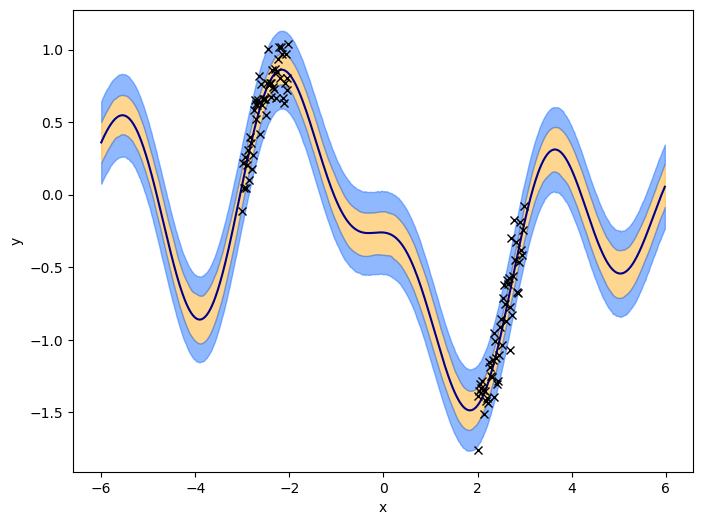

In [13]:
from experiments.src.factory import small
import optax
blr.BETA=1
meanfield_vi_experiment = BasicMeanFieldGaussianVIExperiment(
    blr, gp_data, num_samples=400,
    max_iter=200_000,
    lr_schedule=optax.piecewise_constant_schedule(-0.0001, {40_000: 0.5, 80_000: 0.5}),
    num_particles=64, num_eval_particles=1,
    init_scale=1e-2,
)
meanfield_vi_experiment.train(
    random.PRNGKey(1)
)
blr.BETA=1.
meanfield_vi_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = meanfield_vi_experiment.make_plots()

sample: 100%|██████████| 3000/3000 [02:13<00:00, 22.39it/s, 127 steps of size 1.82e-02. acc. prob=0.94]



MCMC elapsed time: 135.94333052635193


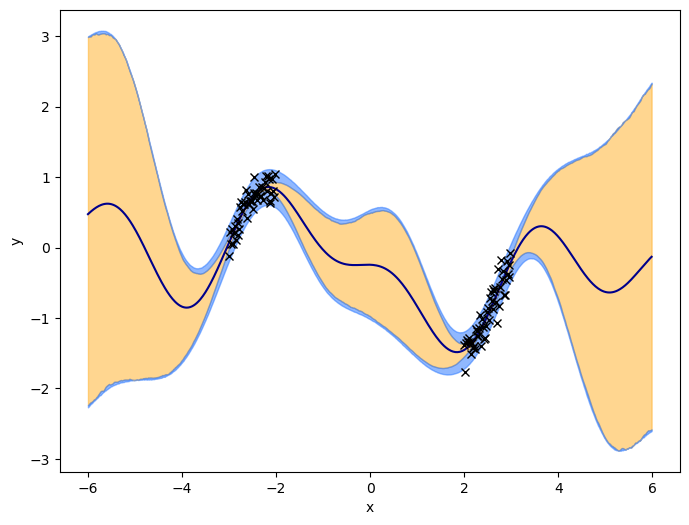

In [14]:
hmc_experiment = BasicHMCExperiment(
    blr,
    gp_data,
)
hmc_experiment.train(
    random.PRNGKey(1)
)
hmc_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = hmc_experiment.make_plots()

Initial eval loss: 2634.4773 (lik: -2601.4092, kl: 33.0680)


100%|██████████| 50/50 [00:21<00:00,  2.28it/s, init loss: 2634.4773, avg. train loss / eval. loss [147000-150000]: -29.3359 / -29.3359]



SVI elapsed time: 22.063425302505493


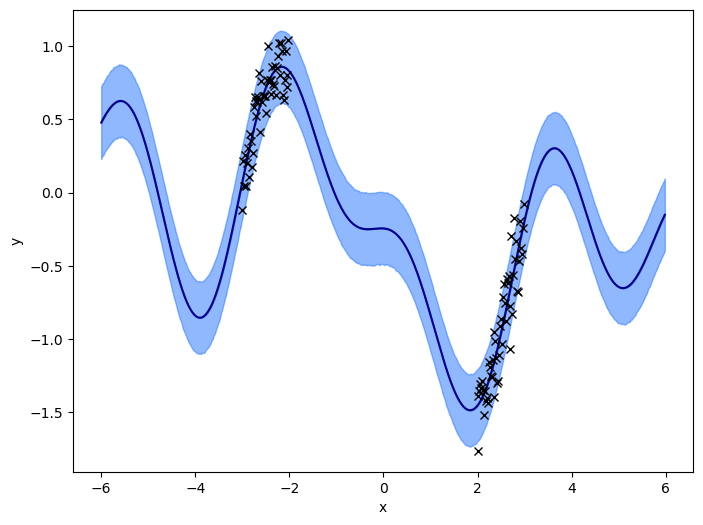

In [15]:
from experiments.src.factory import small
import optax
delta = AutoDeltaVIExperiment(
    blr, gp_data, max_iter=150_000,
    lr_schedule=optax.piecewise_constant_schedule(
        -0.0001, {50_000: 0.5}
    ),
)
delta.train(random.PRNGKey(0))
delta.make_predictions(random.PRNGKey(0))
_ = delta.make_plots()

sample: 100%|██████████| 300000/300000 [02:39<00:00, 1882.74it/s, 300000 steps of size 8.00e-07.]



MCMC elapsed time: 159.380446434021


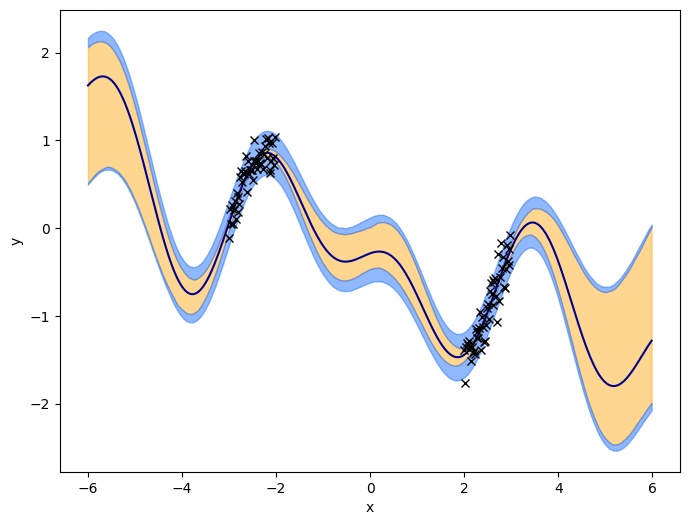

In [17]:
sgld_experiment = BasicSGLDExperiment(
    blr, gp_data,
    init_params={"w": delta._params['w_loc']},
    init_step_size=2*1e-6,
    final_step_size=8*1e-7,
    thinning=250,
    num_warmup=50_000,
    num_samples=250_000,
    num_chains=1,
)
sgld_experiment.train(
    random.PRNGKey(1)
)
sgld_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = sgld_experiment.make_plots()


Laplace mean % = 0.0


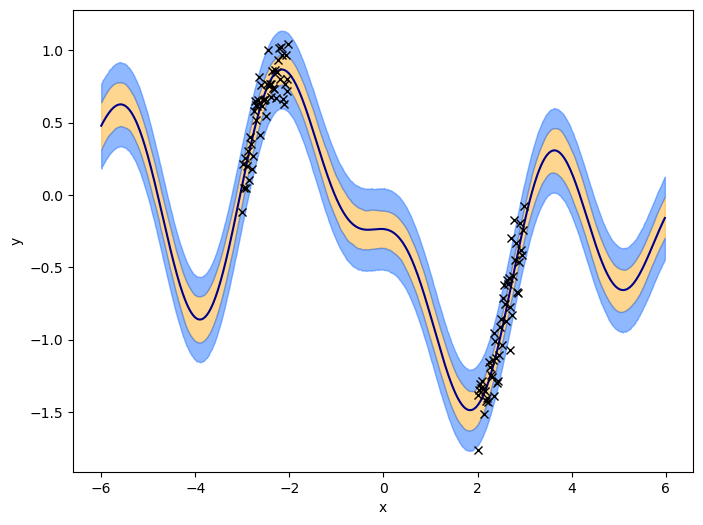

In [18]:
diag_laplace_experiment = AutoDiagonalLaplaceExperiment(
    blr, gp_data,
    trained_map_experiment=delta,
    # num_samples=400,
    # max_iter=40_000,
    # lr_schedule=optax.piecewise_constant_schedule(-0.0001, {75_000: 0.5, 150_000: 0.5}),
    # num_particles=16, num_eval_particles=1,
    shrink=0.,
)
diag_laplace_experiment.train(
    random.PRNGKey(1)
)
diag_laplace_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = diag_laplace_experiment.make_plots()

Laplace mean % = 0.0


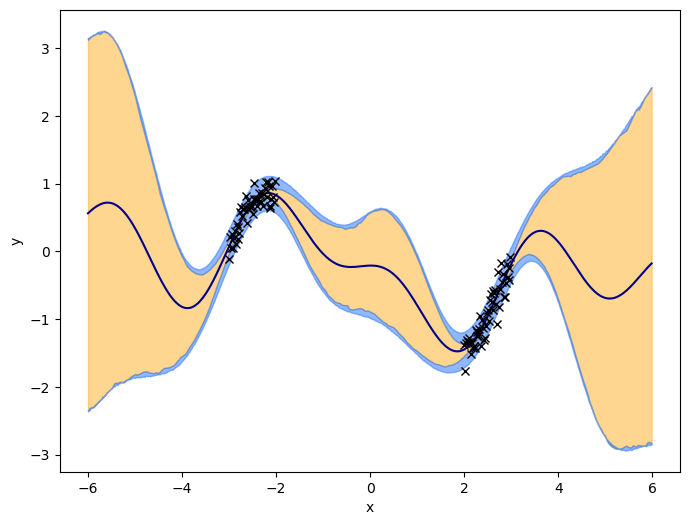

In [19]:
fullrank_laplace_experiment = AutoFullRankLaplaceExperiment2(
    blr, gp_data,
    trained_map_experiment=delta,
    # num_samples=400,
    # max_iter=40_000,
    # lr_schedule=optax.piecewise_constant_schedule(-0.0001, {75_000: 0.5, 150_000: 0.5}),
    # num_particles=16, num_eval_particles=1,
    shrink=0,
)
fullrank_laplace_experiment.train(
    random.PRNGKey(1)
)
fullrank_laplace_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = fullrank_laplace_experiment.make_plots()

Initial eval loss: 1249.3635 (lik: -1227.5273, kl: 21.8361)


100%|██████████| 50/50 [01:19<00:00,  1.59s/it, init loss: 1402.7300, avg. train loss / eval. loss [392000-400000]: -31.9139 / -33.7788]



SVI elapsed time: 80.40246963500977


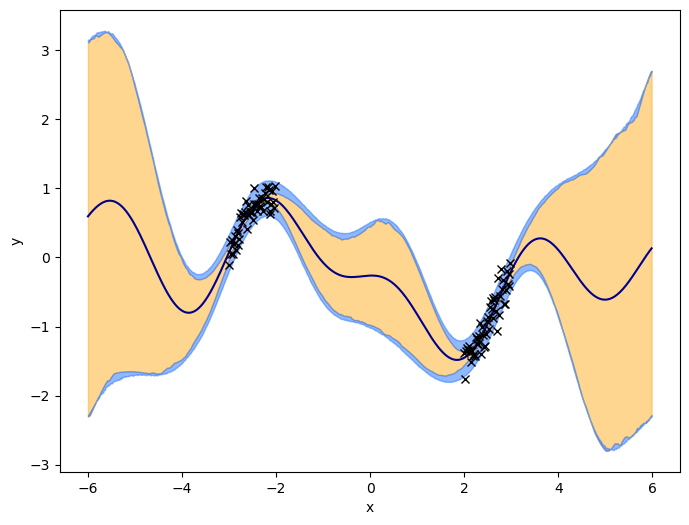

In [20]:
from experiments.src.factory import small
import optax
fullrank_vi_experiment = BasicFullRankGaussianVIExperiment(
    blr, gp_data, num_samples=400,
    max_iter=400_000,
    lr_schedule=optax.piecewise_constant_schedule(-0.0001, {75_000: 0.5, 150_000: 0.5}),
    num_particles=1, num_eval_particles=1,
)
fullrank_vi_experiment.train(
    random.PRNGKey(1)
)
fullrank_vi_experiment.make_predictions(
    random.PRNGKey(1)
)
_ = fullrank_vi_experiment.make_plots()

In [31]:
plt.rcParams.update({
    "axes.grid": True,  # show grid by default
    "axes.titlesize": 20,
    "axes.titlepad": 10.0,
    "axes.labelsize": 18,
    # "figure.constrained_layout.use": True,
    "figure.titlesize": 22,
    "figure.subplot.wspace": 0.3,
    "font.size": 15,
    "font.weight": "normal",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "legend.frameon": False, # No frame on legend
    "lines.linewidth": 1,  # thick lines
    "lines.color": "k",  # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "grid.alpha": 0.3,
    "grid.rasterized": True,
    "savefig.dpi": 300,  # higher resolution output.
    # Set Helvetica as the default font
    "pdf.use14corefonts": True,  # Ensures Type 1 fonts (including Helvetica) are used
    "figure.figsize": [4, 3],
    "axes.unicode_minus": False,
})

KeyError: 'grid.rasterized is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

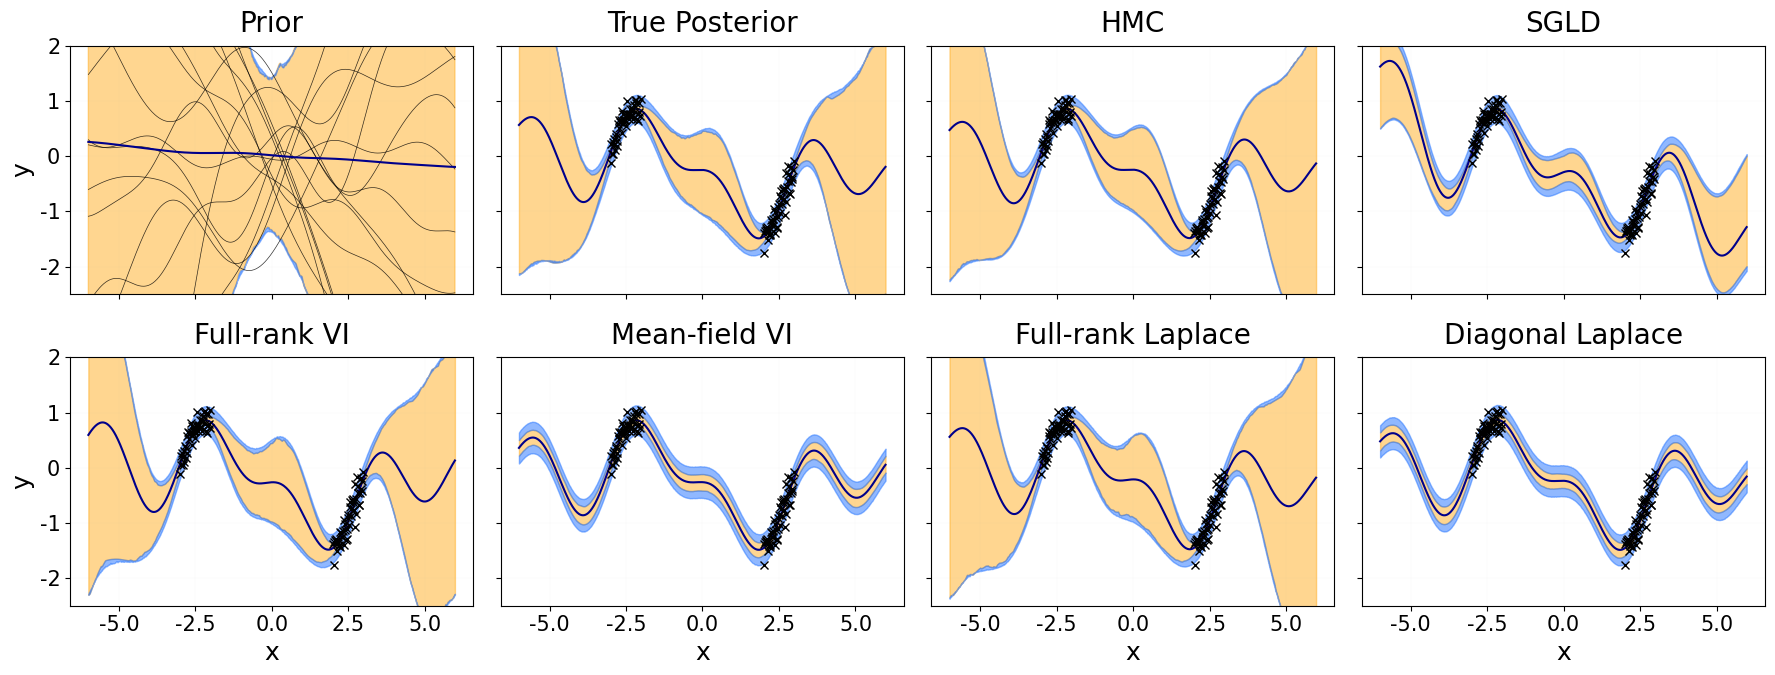

In [32]:
import copy
from experiments.src.data import DataSlice
fig, axs = plt.subplots(figsize=(18, 7), nrows=2, ncols=4, sharex=True, sharey=True)

for ax, (name, experiment) in zip(axs.ravel(), {
    'Prior': prior_experiment,
    'True Posterior': true_experiment,
    'HMC': hmc_experiment,
    'SGLD': sgld_experiment,
    'Full-rank VI': fullrank_vi_experiment,
    'Mean-field VI': meanfield_vi_experiment,
    'Full-rank Laplace': fullrank_laplace_experiment,
    'Diagonal Laplace': diag_laplace_experiment,
}.items()):
    if name == 'Prior':
        overridden_prior_experiment = copy.deepcopy(experiment)
        overridden_prior_experiment._predictions = experiment._predictions
        overridden_prior_experiment._bnn = blr
        overridden_prior_experiment._data = DataSlice(experiment._data, slice(1,1))
        _ = overridden_prior_experiment.make_plots(fig=fig, ax=ax, plot_samples=True, num_extend_samples=150, xlabel=False)
    else:
        _ = experiment.make_plots(fig=fig, ax=ax, xlabel=name in {'Full-rank VI', 'Mean-field VI', 'Full-rank Laplace', 'Diagonal Laplace'},
                                                  ylabel=name in {'Full-rank VI'})
    ax.set_title(name)
    ax.set_ylim(-2.5, 2.)

fig.tight_layout()
fig.savefig("figs/tractable_posterior.pdf")